In [43]:
import pandas as pd
import pandas_ta as ta
from tqdm import tqdm

In [230]:
import vectorbt as vbt

def try_macd_mfi(ticker, last_n_days: int, sensitivity: int):
    df = pd.read_csv(f"../data/1d/{ticker}.csv")
    df = df.iloc[-last_n_days:]

    # MACD - MACD is fast day, MACDs is signal (baseline)
    df["MACD_fast"] = df.ta.ema(length=12)
    df["MACD_slow"] = df.ta.ema(length=26)
    df["MACD_hist"] = df["MACD_fast"] - df["MACD_slow"]
    df["MACD_signal"] = df["MACD_hist"].rolling(9).mean()
    df["MACD_TREND"] = df["MACD_hist"] > df["MACD_signal"]
    df["MACD_TREND"] = df["MACD_TREND"].rolling(sensitivity).sum() > 0

    # MFI - Money Flow Index
    df.ta.mfi(append=True)
    df["MFI_TREND"] = df["MFI_14"] < 20
    df["MFI_TREND"] = df["MFI_TREND"].rolling(sensitivity).sum() > 0

    # SMA 200 - to only buy if price is above 200 day moving average (bullish trend)
    df.ta.sma(length=100, append=True)
    df["SMA_100_TREND"] = df["Close"] > df["SMA_100"]

    df["SIGNAL"] = df["MACD_TREND"] & df["MFI_TREND"] & df["SMA_100_TREND"]
    strategy = df.ta.tsignals(df["SIGNAL"], asbool=True, append=True)

    # Create the Signals Portfolio
    pf = vbt.Portfolio.from_signals(df["Close"], entries=strategy.TS_Entries, exits=strategy.TS_Exits, freq="D", init_cash=100_000, fees=0, slippage=0)
    # Print Portfolio Stats and Return Stats
    # print(pf.stats())
    # print(pf.returns_stats())
    return pf
    

In [231]:
pf = try_macd_mfi("NVDA", 1000, 10)
print(pf.stats())
print(pf.returns_stats())
pf.plot().show()

Start                                       1518
End                                         2517
Period                        1000 days 00:00:00
Start Value                             100000.0
End Value                          107807.218782
Total Return [%]                        7.807219
Benchmark Return [%]                  777.411492
Max Gross Exposure [%]                     100.0
Total Fees Paid                              0.0
Max Drawdown [%]                        5.293193
Max Drawdown Duration          249 days 00:00:00
Total Trades                                   2
Total Closed Trades                            2
Total Open Trades                              0
Open Trade PnL                               0.0
Win Rate [%]                                50.0
Best Trade [%]                           12.1315
Worst Trade [%]                        -3.856438
Avg Winning Trade [%]                    12.1315
Avg Losing Trade [%]                   -3.856438
Avg Winning Trade Du

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_63631/3505858794.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_63631/3505858794.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [229]:
nasdaq100 = open("../old/tickers/nasdaq-100.txt", "r").read().splitlines()
nasdaq100 = [(row.replace("^", "-"), "1d") for row in nasdaq100]

returns = []
companies = []

for ticker, interval in tqdm(nasdaq100):
    try:
        pf = try_macd_mfi(ticker, 365, 100)
    except:
        continue
    returns.append(pf.total_return())
    companies.append(ticker)

  0%|          | 0/101 [00:00<?, ?it/s]/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_63631/2181085156.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_63631/2181085156.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/var/folders/gs/c8fmpn2x69s6f023jym_dvdw0000gn/T/ipykernel_63631/2181085156.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future versio

win rate: 0.37
loss rate: 0.35
mean return: 0.01720212504398505
median return: 0.0
max return: 0.8266168568665316
min return: -0.2036214388012774
best performing companies:
CPRT 0.14968579538205828
PANW 0.15155897452193662
FANG 0.15287216181761484
MSFT 0.15643353218673145
VRTX 0.16111640102587887
GFS 0.162363445390915
GILD 0.19116469037577627
PCAR 0.20153217431647513
FTNT 0.2655262012537288
NVDA 0.8266168568665316
distribution of returns:


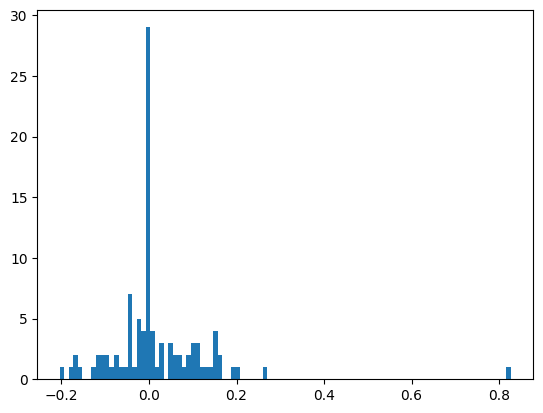

In [219]:
import numpy as np

print("win rate:", np.sum(np.array(returns) > 0) / len(returns))
print("loss rate:", np.sum(np.array(returns) < 0) / len(returns))
print("mean return:", np.mean(returns))
print("median return:", np.median(returns))
print("max return:", np.max(returns))
print("min return:", np.min(returns))

print("best performing companies:")
for i in np.argsort(returns)[-10:]:
    print(companies[i], returns[i])

print('distribution of returns:')
import matplotlib.pyplot as plt
plt.hist(returns, bins=100)
plt.show()